https://medium.com/@rasmushaa/how-to-build-an-optimal-omxh25-portfolio-using-modern-portfolio-theory-and-python-de5a79301c10

Uses certain US Sector ETF downloaded from yfinance

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pycaret

# Yahoo finance
import yfinance as yf

# Datetime
import datetime as dt
from datetime import datetime
from datetime import timedelta

In [2]:
start=pd.to_datetime('2005-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')
period=256           #lookback period for calculation of beta, realized returns

# Load Data

In [3]:
etf_symbols = ["XLB","XLI","XLY","XLP","XLV","XLU","XLK","XLF","XLE","XLC","XLRE","XHB","XRT","XSD"]

In [4]:
etf_tickers = yf.Tickers(etf_symbols)

In [5]:
etf_df = etf_tickers.download(start=start,end=today_date,interval='1D',)   #['Adj Close']

[*********************100%%**********************]  14 of 14 completed


In [6]:
etf_df1=etf_df['Close']

In [7]:
etf_df1

Ticker,XHB,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XRT,XSD
Date,,,,,,,,,,,,,,
2005-01-03,NaN,19.140265,NaN,20.248823,16.581234,21.077536,16.214687,13.905860,NaN,13.933060,21.454443,27.365217,NaN,NaN
2005-01-04,NaN,18.795574,NaN,20.144625,16.423162,20.817486,15.912548,13.857662,NaN,13.836901,21.281883,27.045210,NaN,NaN
2005-01-05,NaN,18.535423,NaN,20.057804,16.395899,20.673780,15.858311,13.785371,NaN,13.619275,21.245935,26.943743,NaN,NaN
2005-01-06,NaN,18.658995,NaN,20.405117,16.477667,20.742207,15.811837,13.851642,NaN,13.690135,21.404119,26.803244,NaN,NaN
2005-01-07,NaN,18.691511,NaN,20.243040,16.390451,20.646410,15.842831,13.917921,NaN,13.690135,21.389734,26.795454,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,107.849998,88.029999,82.309998,86.449997,40.840000,120.599998,197.899994,77.699997,40.650002,72.260002,146.830002,171.179993,72.379997,206.839996
2024-08-06,108.510002,88.480003,83.279999,86.980003,41.500000,122.050003,200.589996,78.239998,41.549999,72.870003,147.509995,173.070007,72.889999,207.669998
2024-08-07,105.650002,87.279999,82.839996,87.330002,41.549999,121.459999,197.339996,78.320000,41.250000,73.279999,146.009995,170.050003,71.489998,201.419998


In [8]:
'''
Training/Testing splits
'''
START_DATE = start
SPLIT_DATE = '2021-12-28'
END_DATE = today_date
etf_df1 = etf_df1.loc[START_DATE:END_DATE]
etf_df1_study = etf_df1.loc[:SPLIT_DATE]
etf_df1_test = etf_df1.loc[SPLIT_DATE:]

# Data Exploration

In [9]:
returns_daily = etf_df1.pct_change(periods=1)
returns_daily.iloc[0,:] = 0 # Fixes the first row from Nan to 0
log_returns = np.log(returns_daily+1)
log_returns_annual = log_returns.mean() * 252 #log returns are addative

In [10]:
cov_daily = log_returns.cov()
cov_annual = cov_daily * 252 # assuming dates are uncorrelated, variance is additive

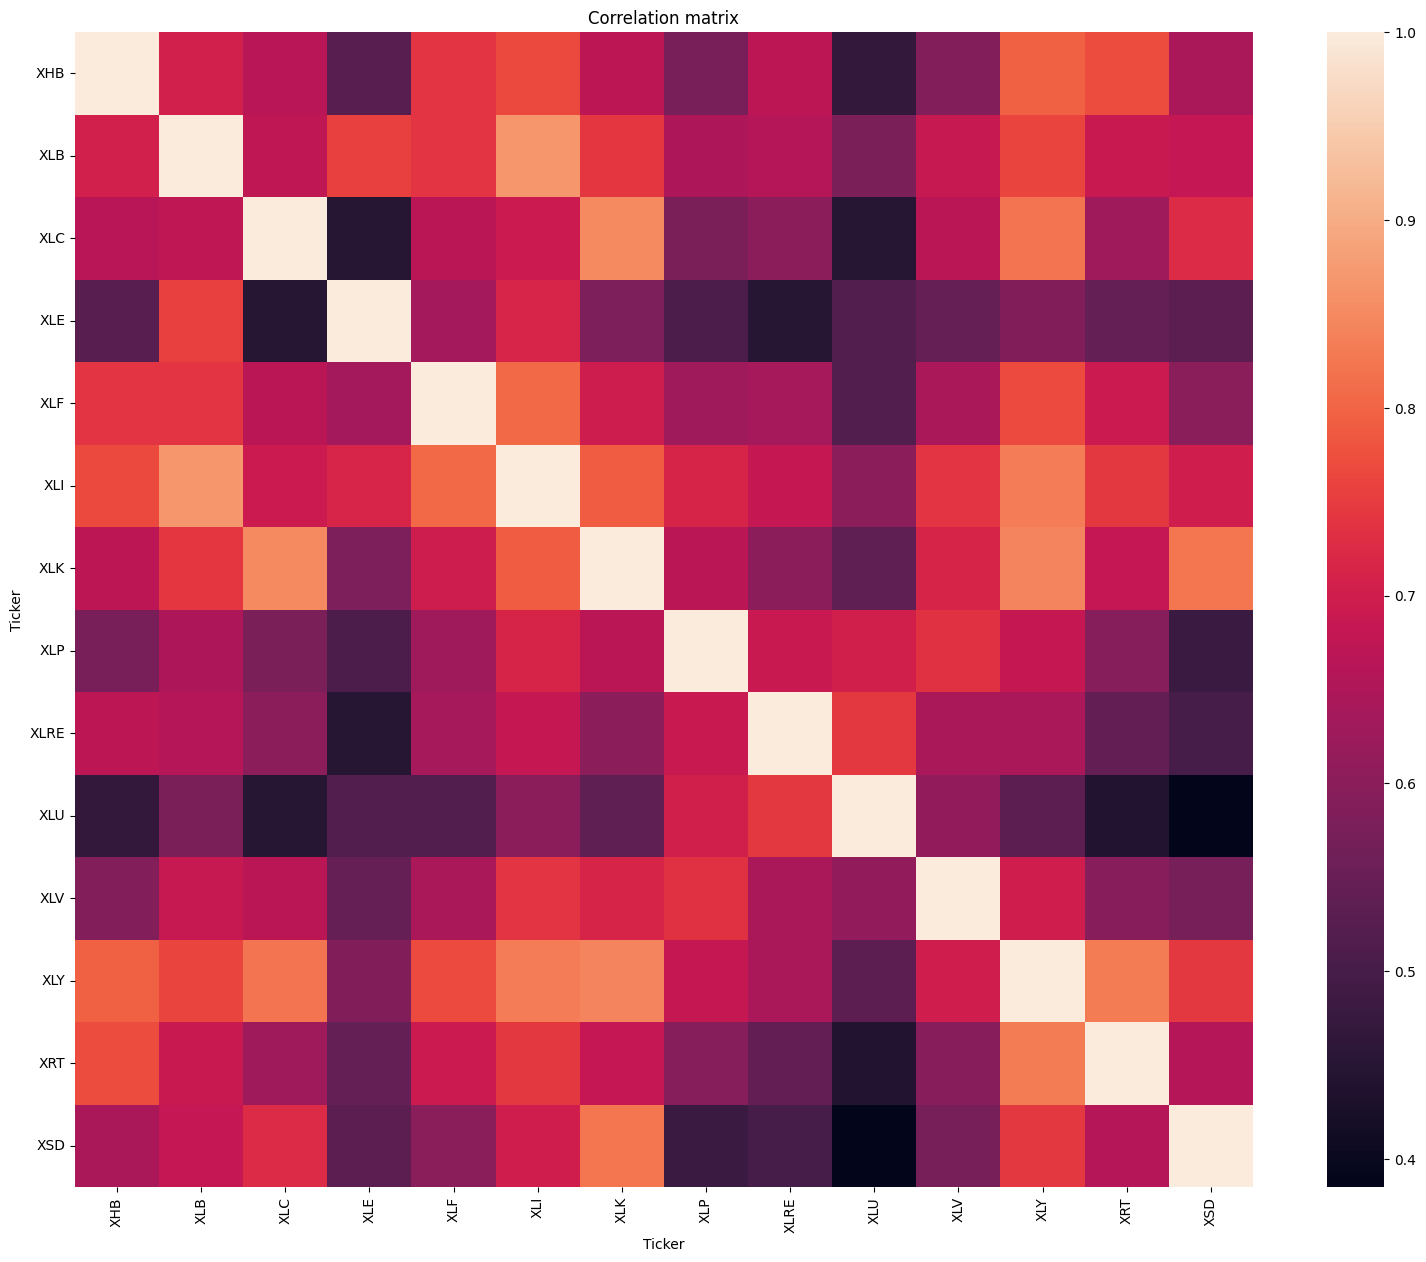

In [11]:
# Correlation matrix
plt.figure('Correlation')
plt.clf()
sns.heatmap(log_returns.corr())
plt.title('Correlation matrix')
plt.gcf().set_size_inches((19,15))
plt.show()

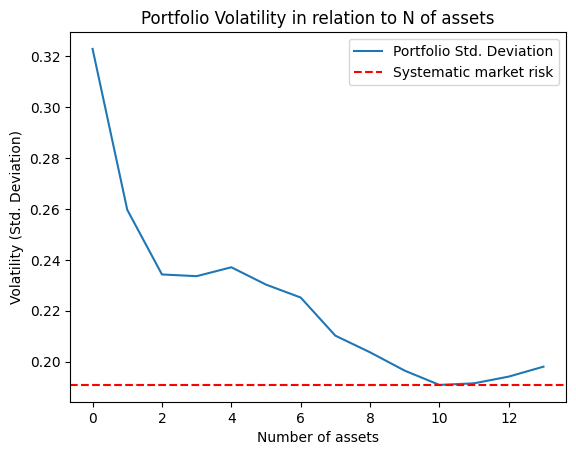

In [12]:
# Portfolio Volatility in realtion to N of assets
num_assets = len(etf_df1.columns)
assets = np.zeros(num_assets)
n_vola = []
for i in range(num_assets):
    assets[i] = 1
    weights = np.divide(assets, np.sum(assets))
    port_vola = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    n_vola.append(port_vola)

plt.figure('Portfolio Standard Deviation')
plt.clf()
plt.plot(n_vola, color='C0', label='Portfolio Std. Deviation')
plt.axhline(min(n_vola), color='red', linestyle='--', label='Systematic market risk')
plt.legend()
plt.xlabel('Number of assets')
plt.ylabel('Volatility (Std. Deviation)') 
plt.title('Portfolio Volatility in relation to N of assets')

plt.subplots_adjust(wspace=0.5)
plt.show()

# MC efficient frontier function

In [13]:
def mc_efficient_frontier(df, num_iterations=500000, min_assets=1):

    returns_daily = df.pct_change(periods=1)+1
    returns_daily.iloc[0,:] = 1 # Fixes the first row from Nan to 1
    log_returns = np.log(returns_daily)
    log_returns_annual = log_returns.mean() * 252 #log returns are addative

    cov_daily = log_returns.cov()
    cov_annual = cov_daily * 252 # assuming dates are uncorrelated, variance is additive

    port_returns = []
    port_volatility = []
    port_sharpe = []
    port_weights = []
    asset_returns = []
    asset_volatility = []
    num_assets = len(df.columns)

    for i in range(num_iterations):

        # Compute random sized portfolio with random assets
        random_portfolio_size = np.random.randint(min_assets, num_assets+1)
        random_assets = np.random.choice(num_assets, size=random_portfolio_size, replace=False)
        # Copmute random normalized weights for each asset
        weights = np.zeros(num_assets)
        weights[random_assets] = np.random.random(random_portfolio_size)
        weights = np.divide(weights, np.sum(weights))
        port_weights.append(weights)

        # Copmutes historical log return of portfolio
        returns = np.dot(weights, log_returns_annual)
        port_returns.append(returns)

        # Copmutes historical volatility of portfolio
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        port_volatility.append(volatility)
        port_sharpe.append(returns / volatility)


    # Get actual asset values
    for i in range(num_assets):
        weights = np.zeros(num_assets)
        weights[i] = 1
        returns = np.dot(weights, log_returns_annual) 
        asset_returns.append(returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        asset_volatility.append(volatility)

    # Final dictionary
    portfolios = {'Returns': port_returns,
                'Volatility': port_volatility,
                'Weights': port_weights,
                'Sharpe': port_sharpe,
                'OptimalReturn': port_returns[np.argmax(port_sharpe)],
                'OptimalVolatility': port_volatility[np.argmax(port_sharpe)],
                'OptimalWeights': port_weights[np.argmax(port_sharpe)],
                'VarianceReturn': port_returns[np.argmin(port_volatility)],
                'VarianceVolatility': port_volatility[np.argmin(port_volatility)],
                'VarianceWeights': port_weights[np.argmin(port_volatility)],
                'Assets': df.columns.tolist(),
                'AssetReturns': asset_returns,
                'AssetVolatility': asset_volatility}

    return portfolios

Portfolio vs highly correlated basket

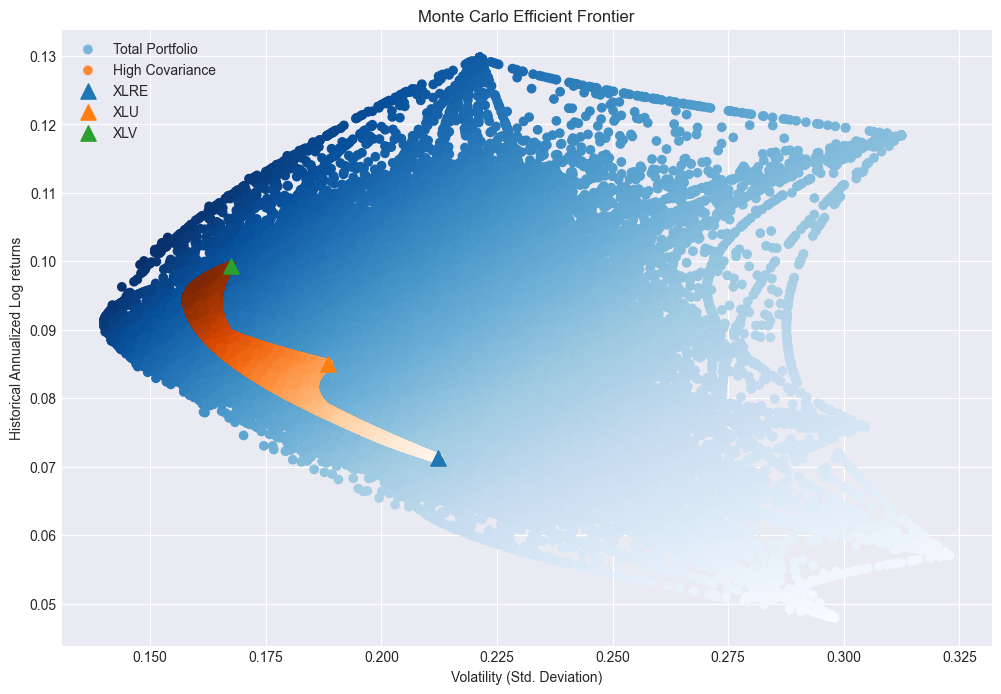

In [16]:
plt.figure('Efficient Frontier Compare' ,figsize=(12, 8))
plt.style.use('seaborn-v0_8-darkgrid')
plt.cla()

portfolios = mc_efficient_frontier(etf_df1, 150000)
plt.scatter(portfolios['Volatility'], portfolios['Returns'], c=portfolios['Sharpe'], cmap='Blues', label='Total Portfolio')

portfolios = mc_efficient_frontier(etf_df1.iloc[:,[8,9,10]], 60000)   #Need to manually select those of high correlation
plt.scatter(portfolios['Volatility'], portfolios['Returns'], c=portfolios['Sharpe'], cmap='Oranges', label='High Covariance')

plt.rcParams["image.cmap"] = 'hsv'
colors  = plt.cm.get_cmap('hsv', len(portfolios['Assets']))
for i in range(len(portfolios['Assets'])):
    plt.scatter(portfolios['AssetVolatility'][i], portfolios['AssetReturns'][i], marker='^', s=120, label=portfolios['Assets'][i])

plt.legend()
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Historical Annualized Log returns') 
plt.title('Monte Carlo Efficient Frontier')
plt.show()

# Efficient frontier

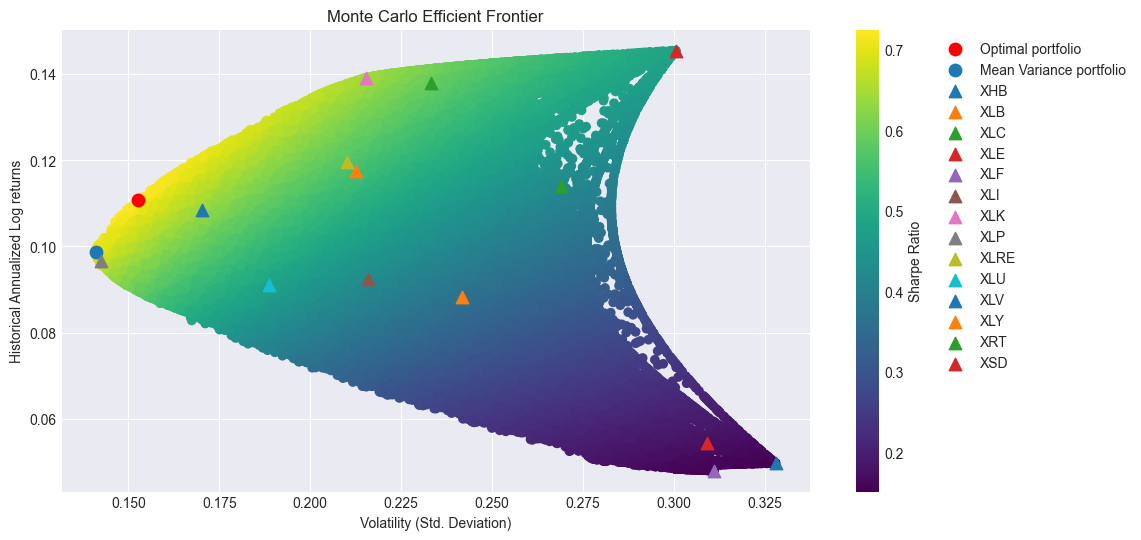

Maximum Sharpe: 0.7256592673987229
Obtained with weights:
Asset: XLK             Weight: 0.27
Asset: XLP             Weight: 0.50
Asset: XLV             Weight: 0.23


In [17]:
plt.figure('Efficient Frontier')
plt.clf()
plt.gcf().set_size_inches((11,6))
plt.subplots_adjust(left=0.05)
plt.style.use('seaborn-v0_8-darkgrid')

portfolios = mc_efficient_frontier(etf_df1_study, min_assets=2)
sc = plt.scatter(portfolios['Volatility'], portfolios['Returns'], c=portfolios['Sharpe'], cmap='viridis')
plt.colorbar(sc).set_label('Sharpe Ratio')

plt.scatter(portfolios['OptimalVolatility'], portfolios['OptimalReturn'], c='red', s=80, label='Optimal portfolio')
plt.scatter(portfolios['VarianceVolatility'], portfolios['VarianceReturn'], c='C0', s=80, label='Mean Variance portfolio')

for i in range(len(portfolios['Assets'])):
    plt.scatter(portfolios['AssetVolatility'][i], portfolios['AssetReturns'][i], marker='^', s=80, label=portfolios['Assets'][i])

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), fancybox=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Historical Annualized Log returns') 
plt.title('Monte Carlo Efficient Frontier')
plt.show()

print('Maximum Sharpe: ' + str(max(portfolios['Sharpe'])))
print('Obtained with weights:')
for i in range(len(portfolios['OptimalWeights'])):
    if portfolios['OptimalWeights'][i] != 0:
        print('Asset: {a:15s} Weight: {w:.2f}'.format(a=portfolios['Assets'][i], w=portfolios['OptimalWeights'][i]))

# Relation between portfolio size and computed values

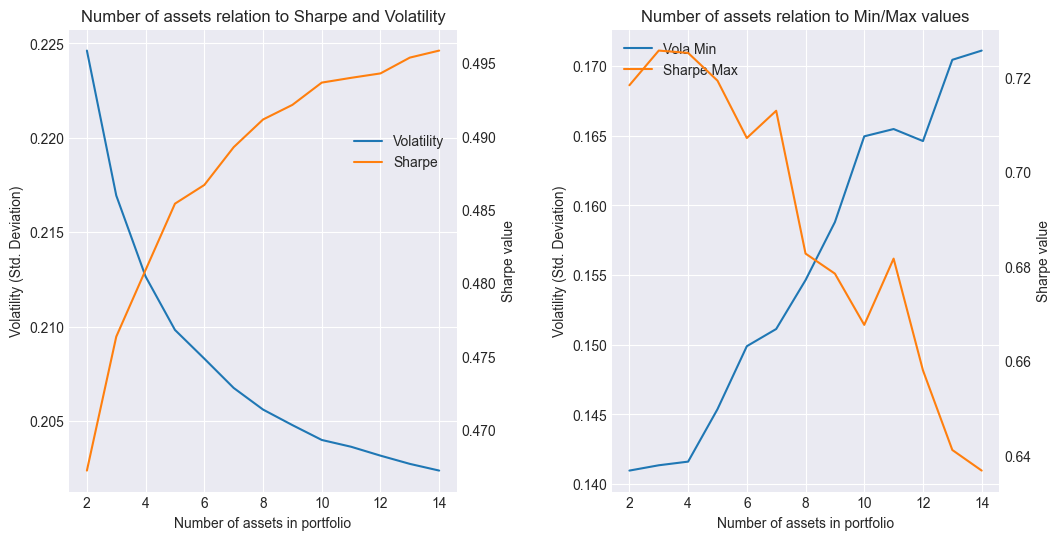

In [18]:
n_assets = np.count_nonzero(portfolios['Weights'], axis=1)

df = pd.DataFrame(n_assets , columns=['Assets'])
df['Vola'] = portfolios['Volatility']
df['Sharpe'] = portfolios['Sharpe']
df = df.set_index('Assets')

df = df.groupby('Assets').agg(Sharpe=('Sharpe', 'mean'), 
                            SharpeMax=('Sharpe', 'max'), 
                            Vola=('Vola', 'mean'),
                            VolaMin=('Vola', 'min'))

fig = plt.figure('Asset number std sharpe')
plt.clf()
plt.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(12)
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df.Vola, color='C0', label='Volatility')
ax2.plot(df.Sharpe, color='C1', label='Sharpe')

ax1.plot(np.nan, 'C1', label = 'Sharpe')
ax1.legend(bbox_to_anchor=(1,0.8))
ax1.set_xlabel('Number of assets in portfolio')
ax1.set_ylabel('Volatility (Std. Deviation)')
ax2.set_ylabel('Sharpe value')
ax2.grid(None)
plt.title('Number of assets relation to Sharpe and Volatility')


plt.subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.4)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df.VolaMin, color='C0', label='Vola Min')
ax2.plot(df.SharpeMax, color='C1', label='Sharpe Max')

ax1.plot(np.nan, 'C1', label = 'Sharpe Max')
ax1.legend()
ax1.set_xlabel('Number of assets in portfolio')
ax1.set_ylabel('Volatility (Std. Deviation)')
ax2.set_ylabel('Sharpe value')
ax2.grid(None)
plt.title('Number of assets relation to Min/Max values')
plt.show()

# Backtesting


In [20]:
small_port = mc_efficient_frontier(etf_df1_study, num_iterations=100000, min_assets=2)
large_port = mc_efficient_frontier(etf_df1_study, num_iterations=100000, min_assets=10)   #Remember to edit min_assets as needed
returns_daily = etf_df1_test.pct_change(periods=1)+1
returns_daily.iloc[0,:] = 1 # Fixes the first row from Nan to 1
cumulative_returns = returns_daily.cumprod()

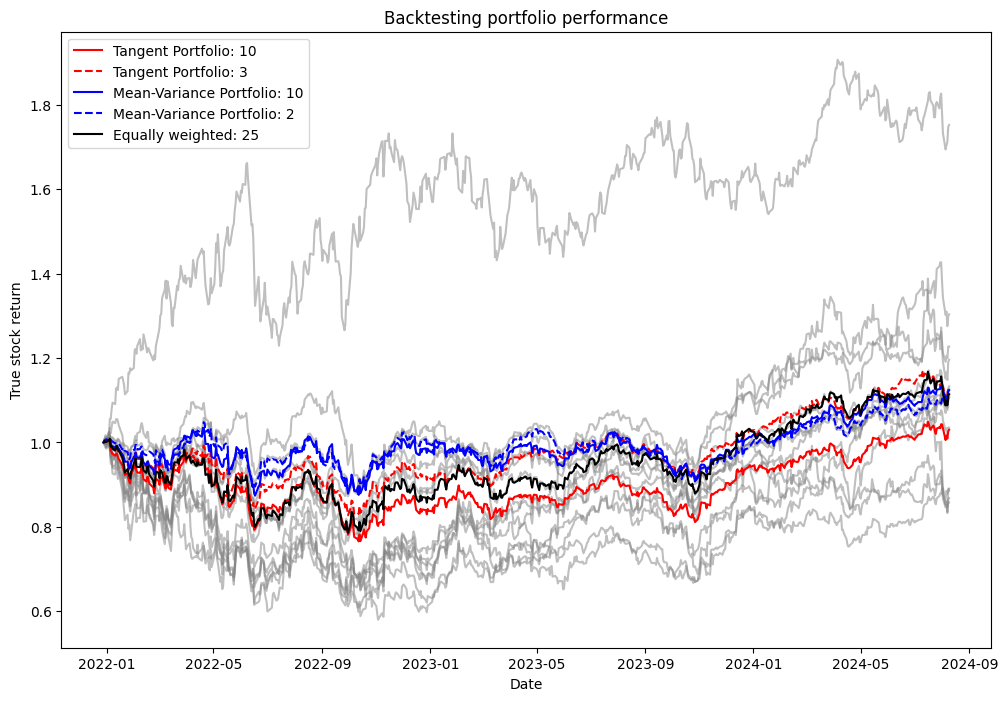

In [21]:
'''
Plotting
'''
plt.figure('Backtesting' ,figsize=(12, 8))
plt.clf()
plt.style.use('default')

# Stocks
plt.plot(returns_daily.cumprod(), color='grey', alpha=0.5)

# Large Optimal portfolio
weighted_returns = cumulative_returns.multiply(large_port['OptimalWeights'] ,axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
plt.plot(portfolio_returns, color='red', label=f'Tangent Portfolio: ' + str(np.count_nonzero(large_port['OptimalWeights'])))

# Small Optimal portfolio
weighted_returns = cumulative_returns.multiply(small_port['OptimalWeights'] ,axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
plt.plot(portfolio_returns, color='red', linestyle='--', label=f'Tangent Portfolio: ' + str(np.count_nonzero(small_port['OptimalWeights'])))

# Large Mean-Variance Portfolio
weighted_returns = cumulative_returns.multiply(large_port['VarianceWeights'] ,axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
plt.plot(portfolio_returns, color='blue', label=f'Mean-Variance Portfolio: ' + str(np.count_nonzero(large_port['VarianceWeights'])))

# Small Mean-Variance Portfolio
weighted_returns = cumulative_returns.multiply(small_port['VarianceWeights'] ,axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
plt.plot(portfolio_returns, color='blue', linestyle='--', label=f'Mean-Variance Portfolio: ' + str(np.count_nonzero(small_port['VarianceWeights'])))

# Equal Weight Portfolio
weights = np.ones(len(etf_df1_study.columns)) 
weights = weights / np.sum(weights)
weighted_returns = cumulative_returns.multiply(weights ,axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
plt.plot(portfolio_returns, color='black', label='Equally weighted: 25')

plt.legend()
plt.xlabel('Date')
plt.ylabel('True stock return')
plt.title(f'Backtesting portfolio performance')
plt.show()

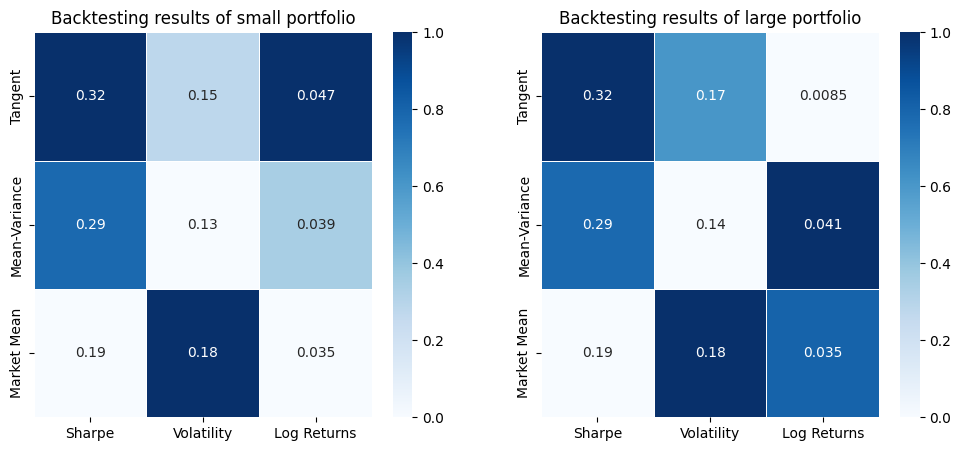

In [22]:
'''
Results
'''
fig = plt.figure('Results')
plt.clf()
fig.set_figheight(5)
fig.set_figwidth(12)

# Mean results
log_returns = np.log(returns_daily)
log_returns_annual = log_returns.mean() * 252 #log returns are addative
cov_daily = log_returns.cov()
cov_annual = cov_daily * 252 # assuming dates are uncorrelated, variance is additive
weights = [1]*len(etf_df1_study.columns)
weights = weights / np.sum(weights)
mean_returns = np.dot(weights, log_returns_annual)
mean_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
mean_sharpe = mean_returns / mean_volatility

# Small Optimal portfolio
weights = small_port['OptimalWeights'] 
weights = weights / np.sum(weights)
optimal_returns = np.dot(weights, log_returns_annual)
optimal_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
optimal_sharpe = optimal_returns / optimal_volatility

# Small Variance results
weights = small_port['VarianceWeights'] 
weights = weights / np.sum(weights)
variance_returns = np.dot(weights, log_returns_annual)
variance_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
variance_sharpe = variance_returns / variance_volatility

# Large Optimal portfolio
weights = large_port['OptimalWeights'] 
weights = weights / np.sum(weights)
large_optimal_returns = np.dot(weights, log_returns_annual)
large_optimal_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
large_optimal_sharpe = optimal_returns / optimal_volatility

# Large Variance results
weights = large_port['VarianceWeights'] 
weights = weights / np.sum(weights)
large_variance_returns = np.dot(weights, log_returns_annual)
large_variance_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
large_variance_sharpe = variance_returns / variance_volatility

plt.subplot(1, 2, 1)
stats = ['Sharpe', 'Volatility', 'Log Returns']
groups = ['Tangent', 'Mean-Variance', 'Market Mean']
values = np.array([[optimal_sharpe, optimal_volatility, optimal_returns],
                    [variance_sharpe, variance_volatility, variance_returns],
                    [mean_sharpe, mean_volatility, mean_returns]])

df = pd.DataFrame(data=values, index=groups, columns=stats)
scaled_df = (df - df.min(axis=0))/(df.max(axis=0) - df.min(axis=0))
sns.heatmap(scaled_df, annot=df, linewidths=0.5, cmap='Blues')
plt.title(f'Backtesting results of small portfolio')

plt.subplot(1, 2, 2)
stats = ['Sharpe', 'Volatility', 'Log Returns']
groups = ['Tangent', 'Mean-Variance', 'Market Mean']
values = np.array([[large_optimal_sharpe, large_optimal_volatility, large_optimal_returns],
                    [large_variance_sharpe, large_variance_volatility, large_variance_returns],
                    [mean_sharpe, mean_volatility, mean_returns]])

df = pd.DataFrame(data=values, index=groups, columns=stats)
scaled_df = (df - df.min(axis=0))/(df.max(axis=0) - df.min(axis=0))
sns.heatmap(scaled_df, annot=df, linewidths=0.5, cmap='Blues')
plt.title(f'Backtesting results of large portfolio')

plt.show()